In [1]:
# Import liberaries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter
from collections import OrderedDict

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

pd.options.plotting.backend = "plotly"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# EDA

In [2]:
data = pd.read_csv('../input/sample/sample_labels.csv')
dataframe = pd.DataFrame(data)
dataframe

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [3]:
data = pd.read_csv('../input/sample/sample_labels.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [4]:
data['Patient Gender'].value_counts().plot.bar()

In [5]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.hist()

In [6]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.box()

In [7]:
data['View Position'].value_counts().plot.bar()

In [8]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

In [9]:
data = data.drop(list(data.iloc[:,1:11].columns.values),axis = 1)
data.iloc[:,1:].sum().plot.barh()

In [10]:
data = data.drop(['No Findings'],axis = 1)
data.iloc[:,1:].sum().plot.barh()

In [11]:
data.iloc[:,1:].mean().plot.barh()

# Loading Dataset and Applying Transforms

In [18]:
class NIH_Dataset(Dataset):

    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,1:].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img,label

In [19]:
data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [20]:
trainds = NIH_Dataset(data,
                      img_dir = '../input/sample/sample/sample/images/',
                      transform = data_transform)

In [21]:
def deprocess(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

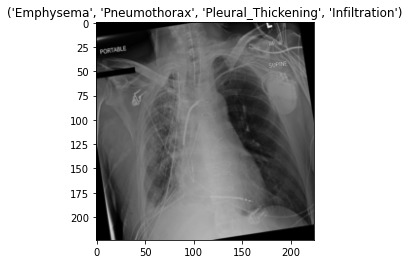

In [22]:
image, label = trainds[0]
class_labels = list(np.where(label==1)[0])
plt.imshow(deprocess(image))
plt.title(itemgetter(*class_labels)(pathology_list));

# Split Dataset and create dataloaders

In [23]:
trainset, validset, testset = random_split(trainds, [5000,303,303])

print("Length of trainset : {}".format(len(trainset)))
print("Length of testset : {}".format(len(testset)))
print("Length of validset : {}".format(len(validset)))

Length of trainset : 5000
Length of testset : 303
Length of validset : 303


In [24]:
trainloader = DataLoader(trainset,
                         batch_size = 32,
                         shuffle = True)

validloader = DataLoader(validset,
                         batch_size = 32,
                         shuffle = False)

testloader = DataLoader(testset,
                        batch_size = 32,
                        shuffle = True)

# Define Pre-trained Model

In [25]:
model = models.resnet18()
model.load_state_dict(torch.load('../input/pretrained-model-weights-pytorch/resnet18-5c106cde.pth'))

<All keys matched successfully>

In [26]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(512, 14),
    nn.Sigmoid()
)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train Model

In [27]:
optimizer = optim.Adam(model.parameters(),
                       lr = 0.0001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor = 0.1,
                                                 patience = 4)
epochs = 10
valid_loss_min = np.Inf

In [28]:
for i in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 

    model.train()
    for images,labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        ps = model(images)
        loss = weighted_loss(pos_weights,neg_weights,ps,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(trainloader)

    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            loss = weighted_loss(pos_weights,neg_weights,ps,labels)
            valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(validloader)

    schedular.step(avg_valid_loss)

    if avg_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
        torch.save({
            'epoch' : i,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'valid_loss_min' : avg_valid_loss
        },'Pneumonia_model.pt')

        valid_loss_min = avg_valid_loss

    print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.873471).   Saving model ...
Epoch : 1 Train Loss : 0.901650 
Epoch : 1 Valid Loss : 0.873471 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.873471 --> 0.858780).   Saving model ...
Epoch : 2 Train Loss : 0.881359 
Epoch : 2 Valid Loss : 0.858780 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.858780 --> 0.850199).   Saving model ...
Epoch : 3 Train Loss : 0.871642 
Epoch : 3 Valid Loss : 0.850199 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.850199 --> 0.841187).   Saving model ...
Epoch : 4 Train Loss : 0.861811 
Epoch : 4 Valid Loss : 0.841187 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.841187 --> 0.837200).   Saving model ...
Epoch : 5 Train Loss : 0.853823 
Epoch : 5 Valid Loss : 0.837200 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.837200 --> 0.817542).   Saving model ...
Epoch : 6 Train Loss : 0.848217 
Epoch : 6 Valid Loss : 0.817542 


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.841346 
Epoch : 7 Valid Loss : 0.826982 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.817542 --> 0.817463).   Saving model ...
Epoch : 8 Train Loss : 0.839505 
Epoch : 8 Valid Loss : 0.817463 


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.832230 
Epoch : 9 Valid Loss : 0.821918 


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

Validation loss decreased (0.817463 --> 0.813502).   Saving model ...
Epoch : 10 Train Loss : 0.825570 
Epoch : 10 Valid Loss : 0.813502 


# Each Class Accuracy

In [29]:
import torch
import pandas as pd

def class_accuracy(dataloader, model, device):
    # Determine the number of classes from the model's output
    num_classes = model(next(iter(dataloader))[0].to(device)).shape[1]

    per_class_accuracy = [0] * num_classes
    total = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            ps = (outputs >= 0.5).float()  # Assuming binary classification

            for i in range(num_classes):
                x1 = ps[:, i:i+1]
                x2 = labels[:, i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

    per_class_accuracy = [(i / len(dataloader.dataset)) * 100.0 for i in per_class_accuracy]

    return per_class_accuracy

def get_acc_data(class_names, acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns=['Labels', 'Acc'])
    return df

# Print Accuracy Report
print("Train Dataset Accuracy Report")
acc_list = class_accuracy(trainloader, model, device)
df = get_acc_data(pathology_list, acc_list)
print(df)


Train Dataset Accuracy Report
                Labels    Acc
0         Cardiomegaly  65.20
1            Emphysema  58.74
2             Effusion  63.82
3               Hernia  71.98
4               Nodule  57.04
5         Pneumothorax  57.00
6          Atelectasis  65.14
7   Pleural_Thickening  53.12
8                 Mass  49.78
9                Edema  72.68
10       Consolidation  66.48
11        Infiltration  60.04
12            Fibrosis  60.84
13           Pneumonia  67.64


In [30]:
import torch
import pandas as pd

def class_accuracy(dataloader, model, device):
    # Determine the number of classes from the model's output
    num_classes = model(next(iter(dataloader))[0].to(device)).shape[1]

    per_class_accuracy = [0] * num_classes

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            ps = (outputs >= 0.5).float()  # Assuming binary classification

            for i in range(num_classes):
                x1 = ps[:, i:i+1]
                x2 = labels[:, i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

    per_class_accuracy = [(i / len(dataloader.dataset)) * 100.0 for i in per_class_accuracy]

    return per_class_accuracy

def get_acc_data(class_names, acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns=['Labels', 'Acc'])
    return df

# Define your device (for example, 'cuda' or 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Print Accuracy Report
print("Valid Dataset Accuracy Report")
acc_list = class_accuracy(validloader, model, device)
df = get_acc_data(pathology_list, acc_list)
print(df)


Valid Dataset Accuracy Report
                Labels        Acc
0         Cardiomegaly  61.716172
1            Emphysema  56.765677
2             Effusion  62.706271
3               Hernia  73.927393
4               Nodule  57.755776
5         Pneumothorax  57.095710
6          Atelectasis  60.066007
7   Pleural_Thickening  55.775578
8                 Mass  48.844884
9                Edema  71.617162
10       Consolidation  65.016502
11        Infiltration  58.085809
12            Fibrosis  60.396040
13           Pneumonia  69.966997
